In [1]:
import os
from os.path import join

import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import warnings
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = 'TNT_VISION'
assert FOLDERNAME is not None, "[!] Enter the foldername."
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/TNT_VISION


In [2]:
df = pd.read_pickle("LSWMD.pkl")

In [3]:
df = df.drop(['waferIndex'], axis = 1)

In [4]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
33093,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",741.0,lot3185,[],[],"(33, 29)"
323023,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4306.0,lot19528,[],[],"(68, 80)"
721333,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1,...",518.0,lot43883,[[Test]],[[none]],"(25, 26)"
590989,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1,...",515.0,lot36910,[],[],"(25, 27)"
213694,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2278.0,lot13591,[],[],"(59, 50)"


In [5]:
df.waferMapDim.value_counts()

(32, 29)    108687
(25, 27)     64083
(49, 39)     39323
(26, 26)     30078
(30, 34)     29513
             ...  
(65, 41)         1
(43, 41)         1
(39, 65)         1
(87, 81)         1
(21, 17)         1
Name: waferMapDim, Length: 632, dtype: int64

In [6]:
failtype = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full','none']
df['FAILTYPE'] = '0'
for ft in failtype:
  df.loc[df['failureType'] == ft,'FAILTYPE'] = ft
df = df.loc[(df.FAILTYPE!= '0')].drop('failureType', axis = 1)

/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [7]:
df

,waferMap,dieSize,lotName,trianTestLabel,waferMapDim,FAILTYPE
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],"(45, 48)",none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],"(45, 48)",none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],"(45, 48)",none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],"(45, 48)",none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],"(45, 48)",none
...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,[[Test]],"(26, 30)",Edge-Loc
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,[[Test]],"(26, 30)",Edge-Loc
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Test]],"(26, 30)",Edge-Ring
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,[[Test]],"(26, 30)",Edge-Loc


In [8]:
df.iloc[:,[0,4,5]]

,waferMap,waferMapDim,FAILTYPE
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",none
...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...","(26, 30)",Edge-Loc
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...","(26, 30)",Edge-Loc
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...","(26, 30)",Edge-Ring
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...","(26, 30)",Edge-Loc


In [9]:
data = df.iloc[:,[0,4,5]]

In [10]:
data = data.reset_index().iloc[:,1:]

In [11]:
data 

,waferMap,waferMapDim,FAILTYPE
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",none
...,...,...,...
172945,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...","(26, 30)",Edge-Loc
172946,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...","(26, 30)",Edge-Loc
172947,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...","(26, 30)",Edge-Ring
172948,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...","(26, 30)",Edge-Loc


In [12]:
NONE = data.loc[(data.FAILTYPE == 'none'),:].sample(20000)
data.drop(data[data.FAILTYPE == 'none'].index, inplace = True)
print(NONE.shape)
print(data.shape)

(20000, 3)
(25519, 3)


In [13]:
data = pd.concat([data, NONE], ignore_index=True)

In [14]:
def linear_resize(x):
  resized_x = cv2.resize(x, dsize=(width, width), interpolation=cv2.INTER_AREA) 
  return resized_x

In [15]:
width = 32
data['resized_wafer']=data.waferMap.apply(linear_resize)

In [16]:
data

,waferMap,waferMapDim,FAILTYPE,resized_wafer
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(53, 58)",Edge-Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(53, 58)",Edge-Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(53, 58)",Edge-Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(53, 58)",Edge-Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,..."
...,...,...,...,...
45514,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","(32, 32)",none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,..."
45515,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(41, 45)",none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,..."
45516,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...","(27, 25)",none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,..."
45517,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(41, 40)",none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,..."


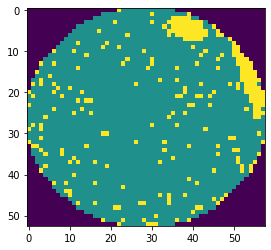

In [17]:
plt.imshow(data['waferMap'][4])

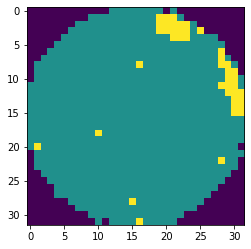

In [18]:
plt.imshow(data['resized_wafer'][4])

In [19]:
images = data.resized_wafer.values
labels = data.FAILTYPE.values
X = np.zeros((len(images), width, width))
for i in range(len(images)):
  X[i,:,:] = images[i]
X = X.reshape((-1, width, width, 1))

In [20]:
print(X.shape)
print(labels.shape)

(45519, 32, 32, 1)
(45519,)


In [21]:
new_x = np.zeros((len(X), width, width, 3))

for w in range(len(X)):
    for i in range(width):
        for j in range(width):
            #print(int(x[w, i, j]))
            new_x[w, i, j, int(X[w, i, j])] = 1

In [22]:

faulty_case = np.unique(labels)
faulty_case_dict =dict()
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(labels[labels==f])))
    faulty_case_dict[i] = f

Center : 4294
Donut : 555
Edge-Loc : 5189
Edge-Ring : 9680
Loc : 3593
Near-full : 149
Random : 866
Scratch : 1193
none : 20000


In [23]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 32, 32, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((20000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 16, 16, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    gen_y = np.full((len(gen_x), 1), label)
    
    return gen_x[1:], gen_y[1:]

In [24]:
# Encoder
input_shape = (32, 32, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )


In [25]:
# start train
ae.summary()
ae.fit(new_x, new_x,
       batch_size=256,
       epochs=20,
       verbose=2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________

In [26]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)
# Make decoder model with part of autoencoder model layers
decoder_input = Input((16, 16, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [27]:
y = np.array(labels).reshape((-1,1))

In [28]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [29]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 25764
Donut : 21090
Edge-Loc : 25945
Edge-Ring : 38720
Loc : 25151
Near-full : 20264
Random : 21650
Scratch : 21474
none : 20000


In [30]:
from tensorflow.keras.utils import to_categorical
for i, l in enumerate(faulty_case):
    y[y==l] = i
    
y = to_categorical(y)

In [31]:
new_x.shape

(220058, 32, 32, 3)

In [32]:
y.shape

(220058, 9)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(new_x, y,
                                                    test_size=0.35,
                                                    random_state=42)

In [34]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (143037, 32, 32, 3), y : (143037, 9)
Test x: (77021, 32, 32, 3), y : (77021, 9)


In [35]:
input_shape = (32, 32, 3)
input_tensor = Input(input_shape)

def create_model():
    input_shape = (32, 32, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    BN_1 = layers.BatchNormalization()(conv_1)
    MP_1 = layers.MaxPool2D(pool_size = (2,2), padding = 'same')(BN_1)

    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(MP_1)
    BN_2 = layers.BatchNormalization()(conv_2)
    MP_2 = layers.MaxPool2D(pool_size = (2,2), padding = 'same')(BN_2)

    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(MP_2)
    BN_3 = layers.BatchNormalization()(conv_3)
    MP_3 = layers.MaxPool2D(pool_size = (2,2), padding = 'same')(BN_3)
    
    flat = layers.Flatten()(MP_3)
    dense_1 = layers.Dense(512, activation='relu')(flat)
    drop_1 = layers.Dropout(0.5)(dense_1)
    dense_2 = layers.Dense(128, activation='relu')(drop_1)
    drop_2 = layers.Dropout(0.5)(dense_2)
    output_tensor = layers.Dense(9, activation='softmax')(drop_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [36]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=128, verbose=2) 
# 5-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=42) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 5-fold model's mean accuracy
print('Class Activation Map Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/10
745/745 - 4s - loss: 0.6625 - accuracy: 0.7646
Epoch 2/10
745/745 - 3s - loss: 0.3323 - accuracy: 0.8854
Epoch 3/10
745/745 - 3s - loss: 0.2228 - accuracy: 0.9267
Epoch 4/10
745/745 - 3s - loss: 0.1635 - accuracy: 0.9462
Epoch 5/10
745/745 - 3s - loss: 0.1227 - accuracy: 0.9611
Epoch 6/10
745/745 - 3s - loss: 0.1039 - accuracy: 0.9667
Epoch 7/10
745/745 - 3s - loss: 0.0898 - accuracy: 0.9728
Epoch 8/10
745/745 - 3s - loss: 0.0735 - accuracy: 0.9764
Epoch 9/10
745/745 - 3s - loss: 0.0691 - accuracy: 0.9781
Epoch 10/10
745/745 - 3s - loss: 0.0612 - accuracy: 0.9809
373/373 - 1s - loss: 0.0833 - accuracy: 0.9765
Epoch 1/10
745/745 - 4s - loss: 0.6881 - accuracy: 0.7561
Epoch 2/10
745/745 - 3s - loss: 0.3398 - accuracy: 0.8832
Epoch 3/10
745/745 - 3s - loss: 0.2259 - accuracy: 0.9257
Epoch 4/10
745/745 - 3s - loss: 0.1639 - accuracy: 0.9469
Epoch 5/10
745/745 - 3s - loss: 0.1274 - accuracy: 0.9599
Epoch 6/10
745/745 - 3s - loss: 0.1080 - accuracy: 0.9660
Epoch 7/10
745/745 - 3s 

In [37]:
history = model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         epochs=20,
         batch_size=128,
         )

Epoch 1/20
1118/1118 - 10s - loss: 0.5756 - accuracy: 0.7955 - val_loss: 0.2499 - val_accuracy: 0.9125
Epoch 2/20
1118/1118 - 7s - loss: 0.2552 - accuracy: 0.9151 - val_loss: 0.1768 - val_accuracy: 0.9372
Epoch 3/20
1118/1118 - 7s - loss: 0.1574 - accuracy: 0.9496 - val_loss: 0.1189 - val_accuracy: 0.9602
Epoch 4/20
1118/1118 - 7s - loss: 0.1161 - accuracy: 0.9634 - val_loss: 0.0896 - val_accuracy: 0.9700
Epoch 5/20
1118/1118 - 7s - loss: 0.0899 - accuracy: 0.9715 - val_loss: 0.1671 - val_accuracy: 0.9442
Epoch 6/20
1118/1118 - 7s - loss: 0.0779 - accuracy: 0.9763 - val_loss: 0.0920 - val_accuracy: 0.9700
Epoch 7/20
1118/1118 - 7s - loss: 0.0661 - accuracy: 0.9793 - val_loss: 0.0845 - val_accuracy: 0.9739
Epoch 8/20
1118/1118 - 7s - loss: 0.0624 - accuracy: 0.9813 - val_loss: 0.0492 - val_accuracy: 0.9853
Epoch 9/20
1118/1118 - 7s - loss: 0.0503 - accuracy: 0.9847 - val_loss: 0.0661 - val_accuracy: 0.9815
Epoch 10/20
1118/1118 - 7s - loss: 0.0480 - accuracy: 0.9861 - val_loss: 0.0583 -

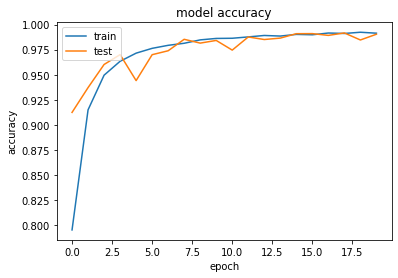

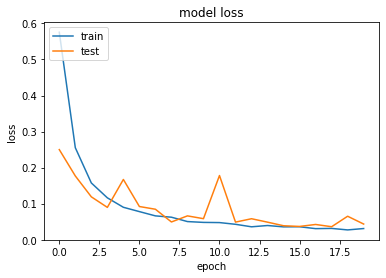

In [38]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()